### Continent specific PFT height allometries 

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

import modp as mp

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Martinez-cano height allometry

In [2]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess = [58.0, 0.73, 21.8]


In [3]:
def fit_d2hmc (df, initial_guess) :
    # remove nas  in dbh and height
    df = df.dropna(subset=['height','dbh'])
    # remove outliers
    df  = df[df['height_outlier']=='N']
   
    height_ps, covariance = curve_fit(f=d2hmc, xdata=np.array(df['dbh']), ydata=np.array(df['height']),
                                           p0=initial_guess)

    return height_ps 

## Final parameters

- Indo-Malaya - Michaelis-Menten equation fit to dipterocarps for everggreen PFT and dry forests hydro-deciduous PFT
- Neo-tropics - Michaelis-Menten equation fit to all rain forest species for evergreen PFT, and dry forest for hydro-deciduous PFT
- Afrotropics - Michaelis-Menten equation fit to rain forest species for evergreen PFT and savanna for hydro-deciduous PFT

In [4]:
df_trop_orig = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv')

rf = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical rain forest']
df = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical dry forest']
s = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical savanna']

In [5]:
initial_guess = [58.0, 0.73, 21.8]
ds = np.arange(1, 250, 1)

### Asia

#### Evergreen - Dipterocarpaceae

In [6]:
rf_asia = rf.loc[rf['realm'] == 'Indo-Malaya']
rf_asia = rf_asia.loc[rf_asia['family'] == 'Dipterocarpaceae']
rf_asia_ps = fit_d2hmc(rf_asia, initial_guess)
curve_rf_asia = [d2hmc(d, rf_asia_ps[0], rf_asia_ps[1], rf_asia_ps[2])  for  d  in ds]

In [7]:
print(rf_asia_ps)

[158.36468951   0.78216249  92.34041828]


#### Hydro-deciduous  - dry forests

In [8]:
df_asia = df.loc[df['realm'] == 'Indo-Malaya']
df_asia_ps = fit_d2hmc(df_asia, initial_guess)
curve_df_asia = [d2hmc(d, df_asia_ps[0], df_asia_ps[1], df_asia_ps[2])  for  d  in ds]

In [9]:
print(df_asia_ps)

[7.13449418e+07 5.87419739e-01 4.28663438e+07]


### Americas

#### Evergreen - rain forests

In [10]:
rf_americas = rf.loc[rf['realm'] == 'Neotropic']
rf_americas_ps = fit_d2hmc(rf_americas, initial_guess)
curve_rf_americas = [d2hmc(d, rf_americas_ps[0], rf_americas_ps[1], rf_americas_ps[2])  for  d  in ds]

In [11]:
print(rf_americas_ps)

[69.6053814   0.80161612 34.7882537 ]


#### Hydro-deciduous - dry forests

In [12]:
df_americas = df.loc[df['realm'] == 'Neotropic']
df_americas_ps = fit_d2hmc(df_americas, initial_guess)
curve_df_americas = [d2hmc(d, df_americas_ps[0], df_americas_ps[1], df_americas_ps[2])  for  d  in ds]

In [13]:
print(df_americas_ps)

[16.21393927  0.84868343  6.89905218]


### Africa

#### Evergreen - rain forest

In [14]:
rf_africa = rf.loc[rf['realm'] == 'Afrotropic']
rf_africa_ps = fit_d2hmc(rf_africa, initial_guess)
curve_rf_africa = [d2hmc(d, rf_africa_ps[0], rf_africa_ps[1], rf_africa_ps[2])  for  d  in ds]

In [15]:
print(rf_africa_ps)

[61.01797595  0.87719445 38.08187347]


#### Hydro-deciduos - savanna

In [16]:
s_africa = s.loc[s['realm'] == 'Afrotropic']
s_africa_ps = fit_d2hmc(s_africa, initial_guess)
curve_s_africa = [d2hmc(d, s_africa_ps[0], s_africa_ps[1], s_africa_ps[2])  for  d  in ds]

In [17]:
s_africa_ps

array([8.25761452e+07, 7.20354641e-01, 7.79363707e+07])

Text(0.02, 0.5, 'Height (m)')

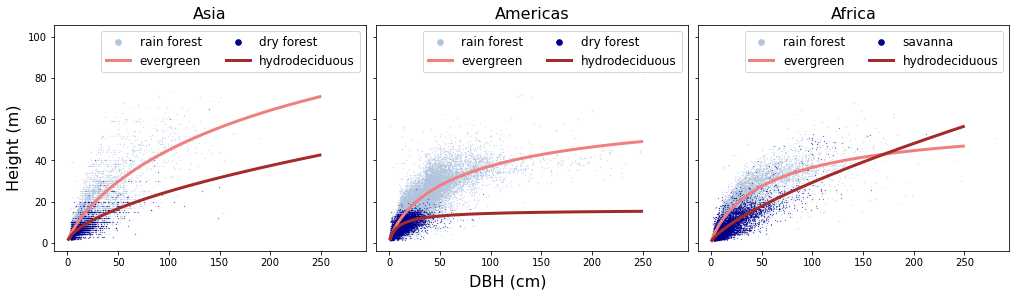

In [18]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(rf_asia['dbh'], rf_asia['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf_asia, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].scatter(df_asia['dbh'], df_asia['height'], s=0.05, color='darkblue', label = 'dry forest')
axs[0].plot(ds, curve_df_asia, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[0].set_title('Asia',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)

axs[1].scatter(rf_americas['dbh'], rf_americas['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[1].plot(ds, curve_rf_americas, color='lightcoral',label='evergreen',linewidth=3.0)
axs[1].scatter(df_americas['dbh'], df_americas['height'], s=0.05, color='darkblue', label = 'dry forest')
axs[1].plot(ds, curve_df_americas, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[1].set_title('Americas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)

axs[2].scatter(rf_africa['dbh'], rf_africa['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[2].plot(ds, curve_rf_africa, color='lightcoral',label='evergreen',linewidth=3.0)
axs[2].scatter(s_africa['dbh'], s_africa['height'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s_africa, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[2].set_title('Africa',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)



### Save the parameter values!

In [19]:
h_continent_ps = pd.DataFrame(rf_americas_ps, columns=['American_rf'])
h_continent_ps['African_rf'] = rf_africa_ps
h_continent_ps['Asian_rf'] = rf_asia_ps
h_continent_ps['American_df'] = df_americas_ps
h_continent_ps['African_s'] = s_africa_ps
h_continent_ps['Asian_df'] = df_asia_ps

In [20]:
h_continent_ps.head(3)

,American_rf,African_rf,Asian_rf,American_df,African_s,Asian_df
0,69.605381,61.017976,158.364690,16.213939,8.257615e+07,7.134494e+07
1,0.801616,0.877194,0.782162,0.848683,7.203546e-01,5.874197e-01
2,34.788254,38.081873,92.340418,6.899052,7.793637e+07,4.286634e+07


In [21]:
h_continent_ps.to_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/h_continent_ps.csv', index=False)

### Current  tropical height allometry

In [22]:
global_h = [d2hmc(d, 78.4087704, 0.8124383, 47.6666164)  for  d  in ds]

Text(0.02, 0.5, 'Height (m)')

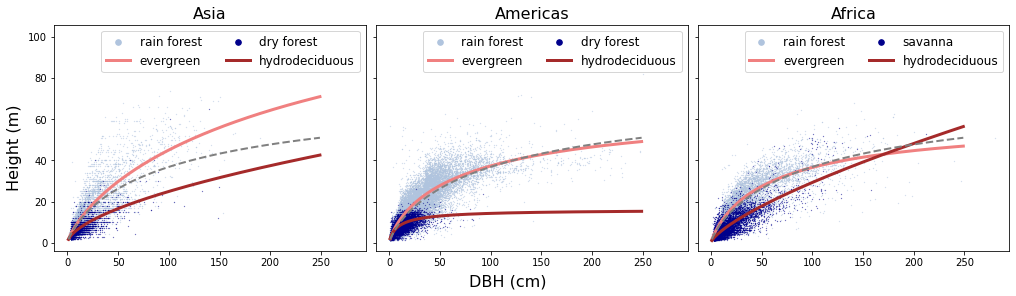

In [23]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(rf_asia['dbh'], rf_asia['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf_asia, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].scatter(df_asia['dbh'], df_asia['height'], s=0.05, color='darkblue', label = 'dry forest')
axs[0].plot(ds, curve_df_asia, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[0].set_title('Asia',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)
axs[0].plot(ds, global_h, color='grey', label='pantropical',linewidth=2.0,linestyle='--')

axs[1].scatter(rf_americas['dbh'], rf_americas['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[1].plot(ds, curve_rf_americas, color='lightcoral',label='evergreen',linewidth=3.0)
axs[1].scatter(df_americas['dbh'], df_americas['height'], s=0.05, color='darkblue', label = 'dry forest')
axs[1].plot(ds, curve_df_americas, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[1].set_title('Americas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)
axs[1].plot(ds, global_h, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


axs[2].scatter(rf_africa['dbh'], rf_africa['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[2].plot(ds, curve_rf_africa, color='lightcoral',label='evergreen',linewidth=3.0)
axs[2].scatter(s_africa['dbh'], s_africa['height'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s_africa, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[2].set_title('Africa',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)
axs[2].plot(ds, global_h, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)

## Pantropical allometry 

In [24]:
df_trop_orig = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv')

rf = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical rain forest']
df = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical dry forest']
s = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical savanna']

dfs = df_trop_orig.loc[df_trop_orig['biome'].isin(['Tropical dry forest','Tropical savanna'])]

In [25]:
initial_guess = [58.0, 0.73, 21.8]

In [26]:
rf_ps = fit_d2hmc(rf, initial_guess)
curve_rf = [d2hmc(d, rf_ps[0], rf_ps[1], rf_ps[2])  for  d  in ds]

In [27]:
df_ps = fit_d2hmc(df, initial_guess)
curve_df = [d2hmc(d, df_ps[0], df_ps[1], df_ps[2])  for  d  in ds]

In [28]:
s_ps = fit_d2hmc(s, initial_guess)
curve_s = [d2hmc(d, s_ps[0], s_ps[1], s_ps[2])  for  d  in ds]

In [29]:
dfs_ps = fit_d2hmc(dfs, initial_guess)
curve_dfs = [d2hmc(d, dfs_ps[0], dfs_ps[1], dfs_ps[2])  for  d  in ds]

Text(0.02, 0.5, 'Height (m)')

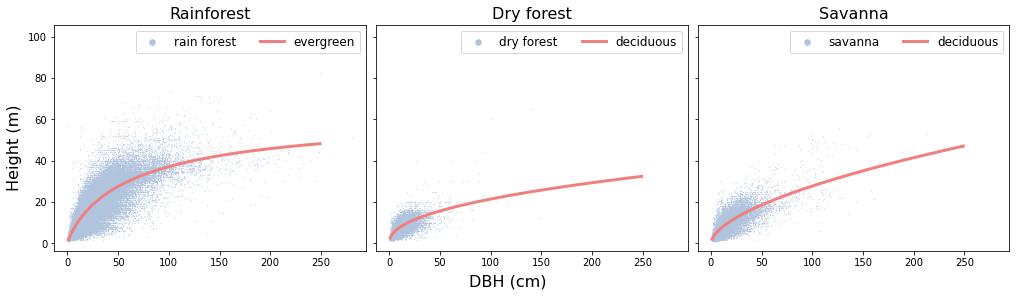

In [30]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(rf['dbh'], rf['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].set_title('Rainforest',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)

axs[1].scatter(df['dbh'], df['height'], s=0.05, color='lightsteelblue', label = 'dry forest')
axs[1].plot(ds, curve_df, color='lightcoral',label='deciduous',linewidth=3.0)
axs[1].set_title('Dry forest',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)

axs[2].scatter(s['dbh'], s['height'], s=0.05, color='lightsteelblue', label = 'savanna')
axs[2].plot(ds, curve_s, color='lightcoral',label='deciduous',linewidth=3.0)
axs[2].set_title('Savanna',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)



### Combining dry forests and savannas 

Text(0.02, 0.5, 'Height (m)')

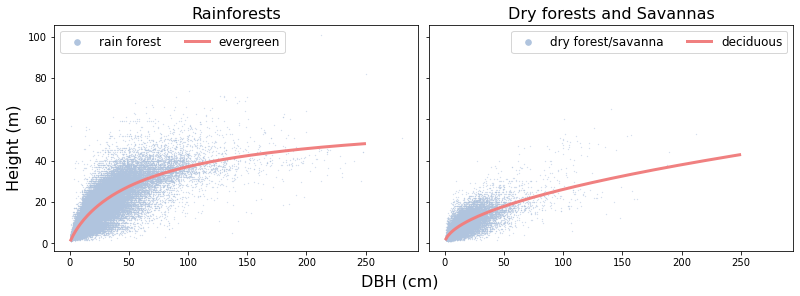

In [31]:
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(rf['dbh'], rf['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].set_title('Rainforests',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)

axs[1].scatter(dfs['dbh'], dfs['height'], s=0.05, color='lightsteelblue', label = 'dry forest/savanna')
axs[1].plot(ds, curve_dfs, color='lightcoral',label='deciduous',linewidth=3.0)
axs[1].set_title('Dry forests and Savannas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)


fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)

In [32]:
h_pantropical_ps = pd.DataFrame(rf_ps, columns=['rainforest'])
h_pantropical_ps['dry_savanna'] = dfs_ps


In [33]:
h_pantropical_ps.head(3)

,rainforest,dry_savanna
0,63.953353,2.210476e+07
1,0.871154,5.447291e-01
2,40.009989,1.042089e+07


In [34]:
h_pantropical_ps.to_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/h_pantropical_ps.csv', index=False)